<a href="https://colab.research.google.com/github/romenlaw/generative/blob/main/ddqm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install deepinv -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 641.9/641.9 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# DeepInv

[User Guide](https://deepinv.github.io/deepinv/user_guide.html#user-guide)

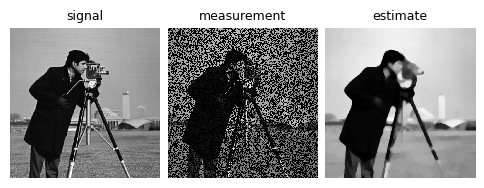

In [ ]:
import deepinv as dinv
from deepinv.utils import load_example
x = load_example("cameraman.png", img_size=512, grayscale=True, device='cpu')
physics = dinv.physics.Inpainting((1, 512, 512), mask = 0.5,
    noise_model=dinv.physics.GaussianNoise(sigma=0.01))
data_fidelity = dinv.optim.data_fidelity.L2()
prior = dinv.optim.prior.PnP(denoiser=dinv.models.MedianFilter())
model = dinv.optim.optim_builder(iteration="HQS", prior=prior, data_fidelity=data_fidelity,
                            params_algo={"stepsize": 1.0, "g_param": 0.1})
y = physics(x)
x_hat = model(y, physics)
dinv.utils.plot([x, y, x_hat], ["signal", "measurement", "estimate"], rescale_mode='clip')

# DDPM
Denoising Diffusion Probabilistic Model

Youtube: [Diffusion Models: DDPM | Generative AI Animated](https://www.youtube.com/watch?v=EhndHhIvWWw)

Github: [DDQM](https://github.com/ytdeepia/DDPM)
# Training

In [ ]:
import torch
import deepinv
from torchvision import datasets, transforms

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


## Load MNIST data

In [ ]:
batch_size = 32
image_size = 32
dataset_name = "mnist"

transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.0,), (1.0,)),
    ]
)
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root="./data", train=True, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True,
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.59MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.24MB/s]


## Diffusion model

In [ ]:
lr = 1e-4
epochs = 100

model = deepinv.models.DiffUNet(in_channels=1, out_channels=1, pretrained=None).to(
    device
)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
mse = deepinv.loss.MSE()

beta_start = 1e-4
beta_end = 0.02
timesteps = 1000

betas = torch.linspace(beta_start, beta_end, timesteps, device=device)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

In [ ]:
for epoch in range(epochs):
    model.train()
    for data, _ in train_loader:
        imgs = data.to(device)
        noise = torch.randn_like(imgs)
        t = torch.randint(0, timesteps, (imgs.size(0),), device=device)

        noised_imgs = (
            sqrt_alphas_cumprod[t, None, None, None] * imgs
            + sqrt_one_minus_alphas_cumprod[t, None, None, None] * noise
        )

        optimizer.zero_grad()
        estimated_noise = model(noised_imgs, t, type_t="timestep")
        loss = mse(estimated_noise, noise)
        loss = loss.mean()
        loss.backward()
        optimizer.step()
    print(f"epoch {epoch}: loss={loss}")
    if epoch % 5 == 0:
        torch.save(
            model.state_dict(),
            f"./checkpoints/ddpm_model_{dataset_name}_epoch_{epoch}.pth",
        )

torch.save(
    model.state_dict(),
    f"./checkpoints/ddpm_model_{dataset_name}.pth",
)

epoch 0: loss=0.018527083098888397
epoch 1: loss=0.010167138651013374
epoch 2: loss=0.00603853864595294
epoch 3: loss=0.012527327984571457
epoch 4: loss=0.008596854284405708
epoch 5: loss=0.006872442550957203
epoch 6: loss=0.006583355367183685
epoch 7: loss=0.010387230664491653
epoch 8: loss=0.01694200560450554
epoch 9: loss=0.006800731178373098
epoch 10: loss=0.00910620205104351
epoch 11: loss=0.003654132829979062
epoch 12: loss=0.007210518233478069
epoch 13: loss=0.015219703316688538
epoch 14: loss=0.01169089786708355
epoch 15: loss=0.010845715180039406
epoch 16: loss=0.011447083204984665
epoch 17: loss=0.010877428576350212
epoch 18: loss=0.01681673340499401
epoch 19: loss=0.006234956905245781
epoch 20: loss=0.00987568125128746
epoch 21: loss=0.004280688241124153
epoch 22: loss=0.008286330848932266
epoch 23: loss=0.008680129423737526
epoch 24: loss=0.012101268395781517
epoch 25: loss=0.016814444214105606
epoch 26: loss=0.01012006402015686
epoch 27: loss=0.012605774216353893
epoch 28:

# Inference

## Load Model from Kaggle

MNIST dataset epoch 30 file: https://www.kaggle.com/models/romenlaw/ddpm-trained-on-mnist/?select=diffusion_model_mnist_epoch_30.pth

In [5]:
import kagglehub

# Download latest version
path = kagglehub.model_download("romenlaw/ddpm-trained-on-mnist/pyTorch/default")

print("Path to model files:", path)
file_path = f"{path}/diffusion_model_mnist_epoch_30.pth"


  0%|          | 0.00/357M [00:00<?, ?B/s]
  0%|          | 1.00M/357M [00:00<02:02, 3.04MB/s]
  1%|          | 4.00M/357M [00:00<00:34, 10.8MB/s]
  3%|▎         | 11.0M/357M [00:00<00:13, 27.8MB/s]
  5%|▌         | 18.0M/357M [00:00<00:09, 36.4MB/s]
  7%|▋         | 26.0M/357M [00:00<00:07, 47.1MB/s]
  9%|▉         | 33.0M/357M [00:00<00:06, 52.7MB/s]
 11%|█         | 39.0M/357M [00:01<00:06, 55.3MB/s]
 13%|█▎        | 46.0M/357M [00:01<00:05, 60.0MB/s]
 15%|█▌        | 54.0M/357M [00:01<00:05, 60.6MB/s]
 17%|█▋        | 62.0M/357M [00:01<00:04, 64.2MB/s]
 19%|█▉        | 69.0M/357M [00:01<00:04, 64.5MB/s]
 21%|██▏       | 76.0M/357M [00:01<00:04, 65.6MB/s]
 23%|██▎       | 83.0M/357M [00:01<00:04, 66.0MB/s]
 25%|██▌       | 90.0M/357M [00:01<00:04, 65.4MB/s]
 27%|██▋       | 97.0M/357M [00:01<00:04, 63.6MB/s]
 29%|██▉       | 105M/357M [00:02<00:04, 62.4MB/s] 
 31%|███▏      | 112M/357M [00:02<00:04, 61.7MB/s]
 33%|███▎      | 118M/357M [00:02<00:04, 61.8MB/s]
 35%|███▍      | 124M/

Path to model files: /root/.cache/kagglehub/models/romenlaw/ddpm-trained-on-mnist/pyTorch/default/1


## Generate Frames

In [8]:
import torch
import numpy as np
import deepinv
from pathlib import Path

device = "cpu"
dataset_name = "mnist"
image_size = 32

checkpoint_path = file_path
model = deepinv.models.DiffUNet(
    in_channels=1, out_channels=1, pretrained=Path(checkpoint_path)
).to(device)

beta_start = 1e-4
beta_end = 0.02
timesteps = 50

betas = torch.linspace(beta_start, beta_end, timesteps, device=device)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

model.eval()

n_samples = 32
n_frames = 100 # nunber of frames to save
frames = [] # for animation
 # Create a list of timesteps to save (more points at the end for better visualization)
if n_frames >= timesteps:
    timesteps_to_save = list(range(timesteps-1, -1, -1))
else:
    # Non-linear (quadratic) timestep spacing to show more detail in later steps
    indices = np.linspace(0, 1, n_frames)**2
    indices = 1 - indices  # Reverse to get more detail at the end
    timesteps_to_save = [int(i * (timesteps-1)) for i in indices]
    timesteps_to_save.sort(reverse=True)

with torch.no_grad():
    x = torch.randn(n_samples, 1, image_size, image_size).to(device)

    for t in reversed(range(timesteps)):
        t_tensor = torch.ones(n_samples, device=device).long() * t

        predicted_noise = model(x, t_tensor, type_t="timestep")

        alpha = alphas[t]
        alpha_cumprod = alphas_cumprod[t]
        beta = betas[t]

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = 0

        x = (1 / torch.sqrt(alpha)) * (
            x - (beta / torch.sqrt(1 - alpha_cumprod)) * predicted_noise
        ) + torch.sqrt(beta) * noise

        if t in timesteps_to_save:
            frames.append(x.cpu().clone())

np.save(f"frames_{dataset_name}_{timesteps}", np.array(frames))

ModuleNotFoundError: No module named 'deepinv'

## Plot

In [ ]:
import matplotlib.pyplot as plt

samples = x.cpu().numpy()

# Plot the generated samples
fig, axes = plt.subplots(4, 8, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    if i < n_samples:
        ax.imshow(samples[i, 0], cmap="gray")
        ax.axis("off")
fig.tight_layout()
plt.savefig("generated_samples.png")
plt.show()

## Animate

In [ ]:
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import HTML

mpl.rcParams['animation.embed_limit'] = 100

# Create the animation
def create_diffusion_animation(frames, filename="ddpm_animation.gif", display=True):
    # Prepare the plot
    n_samples = frames[0].shape[0]
    rows = int(np.ceil(n_samples**0.5))
    cols = int(np.ceil(n_samples / rows))

    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    if rows*cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    # Initialize with empty images
    imgs = []
    for i in range(n_samples):
        img = axes[i].imshow(torch.zeros(28, 28), cmap='gray', vmin=-1, vmax=1)
        axes[i].axis('off')
        imgs.append(img)

    # Set up the animation function
    def animate(i):
        for j in range(n_samples):
            imgs[j].set_array(frames[i][j, 0])
        time_info = plt.suptitle(f'Timestep: {i}/{len(frames)-1}', y=0.95)
        return imgs + [time_info]

    plt.tight_layout()

    # Create the animation
    print("Creating animation...")
    anim = animation.FuncAnimation(
        fig, animate, frames=len(frames), interval=100, blit=False
    )

    # Save as GIF
    anim.save(filename, writer='pillow', fps=10)
    print(f"Animation saved as {filename}")

    if display:
        plt.close()
        return HTML(anim.to_jshtml())
    else:
        plt.close()
        return anim


In [ ]:
anim = create_diffusion_animation(frames, filename=f"ddpm_anim_{dataset_name}_{timesteps}.gif")